In [1]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 100 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.ones(num_steps)*0.0
z0 = np.ones(num_steps) * (np.pi) / (dt*num_steps)



parameter_list=[item for pair in zip(x0, z0) for item in pair] # this makes a list without the inner tuples


In [2]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:20
Elapsed time: 20.3s


In [3]:
def hamiltonian(hx,hz):

    hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
    hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

    return hz_sz + hx_sx

parameterized_system=oqupy.ParameterizedSystem(hamiltonian)



In [4]:
def infidandgrad(paras):
    # take a numpy array hx0, hz0, hx1, hz1, ... over full timesteps
    # return the fidelity and gradient of the fidelity to the global target_state
    reshapedparas=[i for i in (paras.reshape((-1,2))).tolist() for j in range(2)]
    eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state.T,
        process_tensors=[process_tensor],
        parameters=reshapedparas)
    fs=eoinscode['final state']
    gps=eoinscode['gradient']
    fidelity=np.sum(fs*target_state.T)
    for i in range(0,gps.shape[0],2): 
        gps[i,:]=gps[i,:]+gps[i+1,:]
    gps=gps[0::2]
    return 1-fidelity.real,(-1.0*gps.reshape((-1)).real).tolist()

In [5]:
infid,grad=infidandgrad(np.array(parameter_list))

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s


In [6]:
lbx=[-5*np.pi for i in range(num_steps)]
lbz=[-np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ubx=[5*np.pi for i in range(num_steps)]
ubz=[np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ub_list=[item for pair in zip(ubx, ubz) for item in pair]

In [7]:
from scipy.optimize import minimize,Bounds

optimization_result = minimize(
                        fun=infidandgrad,
                        x0=np.array(parameter_list),
                        method='L-BFGS-B',
                        jac=True,
                        bounds=Bounds(lb_list,ub_list),
                        options = {'disp':True,'gtol': 7e-05})

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
El

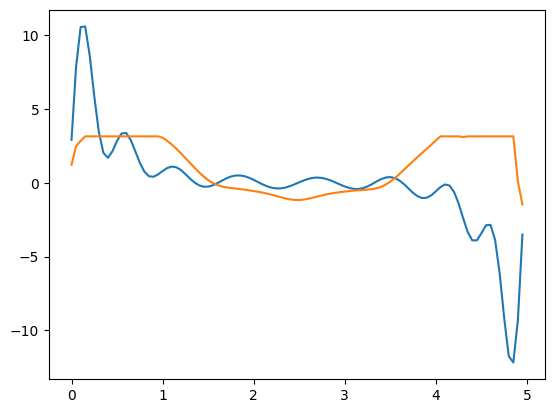

In [8]:
times=dt*np.arange(num_steps)
plt.plot(times,optimization_result['x'][0::2])
plt.plot(times,optimization_result['x'][1::2])